# Problem Statement

Hate  speech  is  an  unfortunately  common  occurrence  on  the  Internet.  Often social media sites like Facebook and Twitter face the problem of identifying and censoring  problematic  posts  while weighing the right to freedom of speech. The  importance  of  detecting  and  moderating hate  speech  is  evident  from  the  strong  connection between hate speech and actual hate crimes. Early identification of users promoting  hate  speech  could  enable  outreach  programs that attempt to prevent an escalation from speech to action. Sites such as Twitter and Facebook have been seeking  to  actively  combat  hate  speech. In spite of these reasons, NLP research on hate speech has been very limited, primarily due to the lack of a general definition of hate speech, an analysis of its demographic influences, and an investigation of the most effective features.

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

[You can download the dataset from here.](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement)

In [1]:
! pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 5.7 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis/train_E6oV3lV.csv
/kaggle/input/twitter-sentiment-analysis/test_tweets_anuFYb8.csv
/kaggle/input/twitter-image/images


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import contractions
import re
import nltk
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from string import punctuation
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
sns.set(style = 'white')
plt.style.use('fivethirtyeight')

In [7]:
train = pd.read_csv('/kaggle/input/twitter-sentiment-analysis/train_E6oV3lV.csv')
test = pd.read_csv('/kaggle/input/twitter-sentiment-analysis/test_tweets_anuFYb8.csv')

In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


# Data Cleaning

In [10]:
def clean_words(string):

    string = re.sub(r'@[\w]*',' ', string)
    string = re.sub(r'[^a-z A-Z#]', ' ', string)
    tokenize = word_tokenize(string)
    stop_words = stopwords.words('english')
    words = []
    lemmatizer = WordNetLemmatizer()
    for word in tokenize:
        if word not in punctuation:
            if word not in stop_words: 
                word.strip()
                word = contractions.fix(word)
                word = word.lower()
                word = lemmatizer.lemmatize(word, pos='v')
                if len(word) > 3:
                    words.append(word)
    return ' '.join(words)

# Exploratory Data Analysis

### Most used Words

In [11]:
corpus = train['tweet'].transform(lambda x: clean_words(x)).to_list()
document = ' '.join(corpus)
words = word_tokenize(document)

In [12]:
freqDist = FreqDist(words)
freqDist

FreqDist({'love': 3112, 'happy': 1707, 'time': 1264, 'like': 1237, 'make': 1226, 'life': 1176, 'today': 1095, 'people': 997, 'father': 957, 'thankful': 952, ...})

In [13]:
df = pd.DataFrame(freqDist, index=[0]).T
df = df.sort_values(by=0, ascending=False)
df.reset_index(inplace=True)
df.columns = ['words','count']

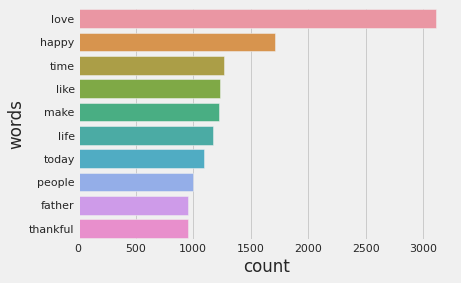

In [14]:
sns.barplot(data = df.head(10), y='words', x='count',orient='h');

### WordCloud for Most used words

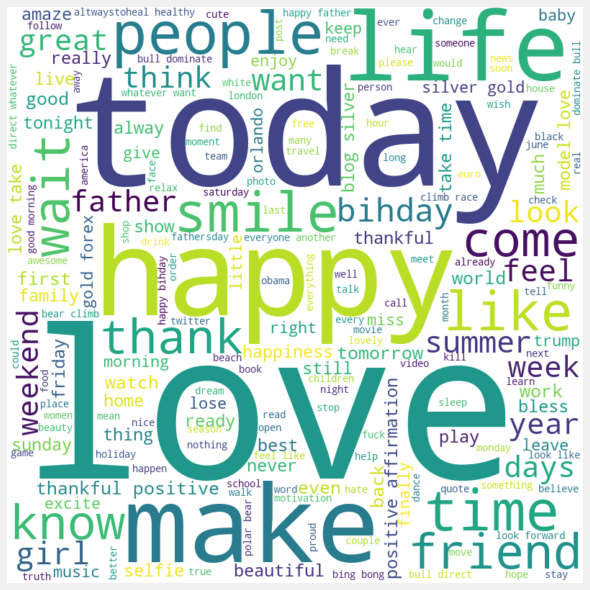

In [15]:
word_string = ' '.join(words)
stop_words = stopwords.words('english')
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(word_string)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

User is the most used word in the dataset and it is most likely because of tagging other people's ids. If we omit user, we have love, happily, like, life, time as the most used words in the dataset.

### WordCloud for Most used words in Positive Tweets

In [16]:
cleaned_df = pd.DataFrame({'cleaned_tweet':corpus,'label':train.label})
cleaned_df.head()

,cleaned_tweet,label
0,father dysfunctional selfish drag dysfunction,0
1,thank lyft credit because offer wheelchair van...,0
2,bihday majesty,0
3,model love take time you are,0
4,factsguide society motivation,0


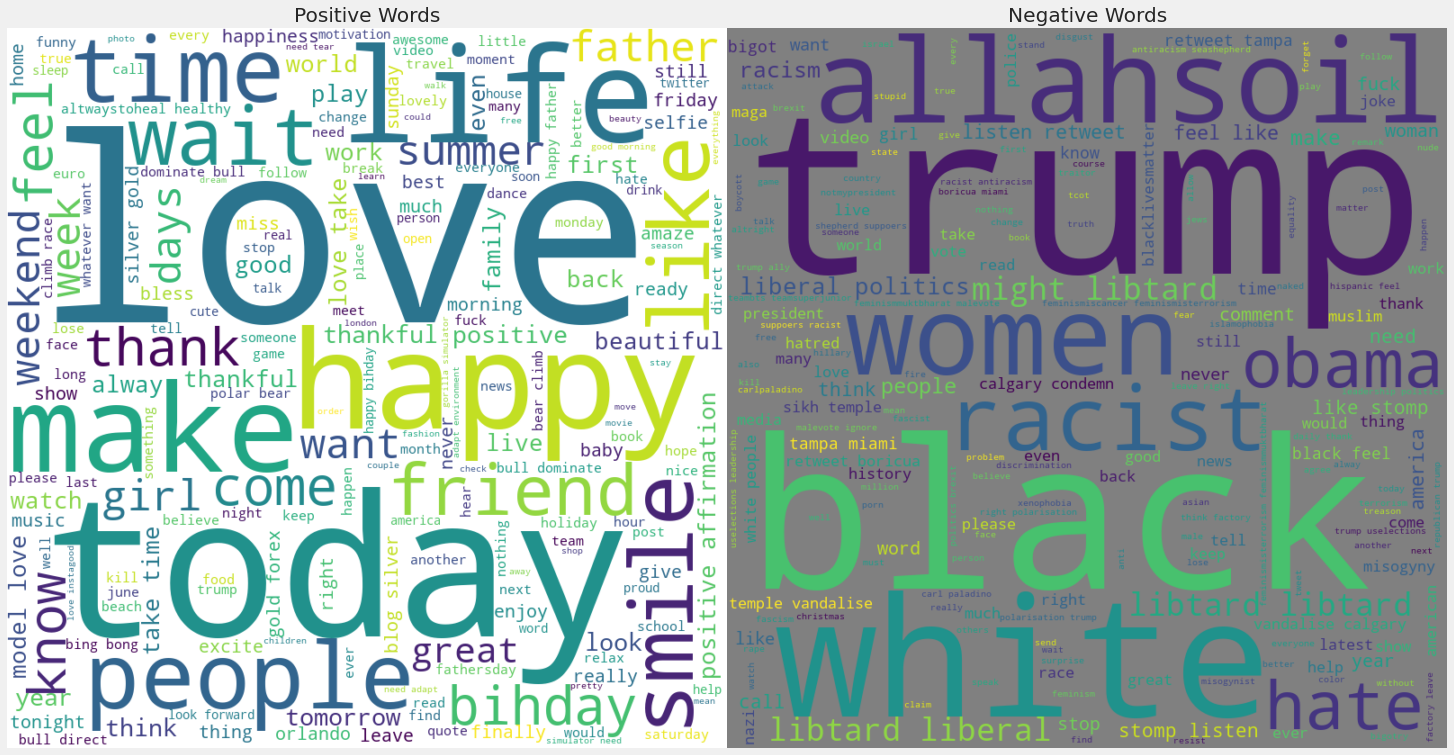

In [17]:
fig,ax = plt.subplots(ncols=2,figsize = (20,20), facecolor = None)

positive_tweets = cleaned_df[cleaned_df['label']==0]['cleaned_tweet'].to_list()

positive_string = ' '.join(positive_tweets)

negative_tweets = cleaned_df[cleaned_df['label']==1]['cleaned_tweet'].to_list()

negative_string = ' '.join(negative_tweets)

positive_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 4).generate(positive_string)

negative_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='grey',
                stopwords = stop_words,
                min_font_size = 4).generate(negative_string)

ax[0].set_title("Positive Words")
ax[0].imshow(positive_wordcloud, interpolation='bilinear')
ax[0].axis("off")

ax[1].set_title("Negative Words")
ax[1].imshow(negative_wordcloud, interpolation='bilinear')
ax[1].axis("off")

plt.tight_layout(pad = 0)

# Training Machine learning Models

### Splitting the data into train data and test data

In [18]:
tweets = train['tweet'].transform(lambda x: clean_words(x))
train_x,test_x,train_y,test_y = train_test_split(tweets, train['label'],random_state=42, stratify=train['label'],test_size=0.2)

In [19]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectorizer.fit(train_x)
len(vectorizer.get_feature_names())

100000

In [20]:
train_x = vectorizer.transform(train_x)
test_x = vectorizer.transform(test_x)

### 1. Logistic Regression

In [21]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(train_x,train_y)
print(classification_report(train_y,lr.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,lr.predict(test_x))) #0.66

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23775
           1       0.80      1.00      0.89      1794

    accuracy                           0.98     25569
   macro avg       0.90      0.99      0.94     25569
weighted avg       0.99      0.98      0.98     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5945
           1       0.56      0.76      0.65       448

    accuracy                           0.94      6393
   macro avg       0.77      0.86      0.81      6393
weighted avg       0.95      0.94      0.95      6393



In [22]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search_lr = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_search_lr.fit(train_x,train_y)

print(classification_report(train_y,grid_search_lr.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,grid_search_lr.predict(test_x))) #74.11

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       1.00      0.99      1.00      1794

    accuracy                           1.00     25569
   macro avg       1.00      1.00      1.00     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.83      0.62      0.71       448

    accuracy                           0.96      6393
   macro avg       0.90      0.80      0.85      6393
weighted avg       0.96      0.96      0.96      6393



### 2. Bernoulli Naive Bayes

In [23]:
bnb = BernoulliNB()
bnb.fit(train_x,train_y)
print(classification_report(train_y,bnb.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,bnb.predict(test_x)))  #0.40

              precision    recall  f1-score   support

           0       0.93      1.00      0.97     23775
           1       1.00      0.06      0.12      1794

    accuracy                           0.93     25569
   macro avg       0.97      0.53      0.54     25569
weighted avg       0.94      0.93      0.91     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5945
           1       1.00      0.03      0.06       448

    accuracy                           0.93      6393
   macro avg       0.97      0.51      0.51      6393
weighted avg       0.94      0.93      0.90      6393



In [24]:
model = BernoulliNB()

alphas = np.arange(0.01,0.1,0.01)
fit_prior=[True,False]

grid = dict(alpha=alphas, fit_prior=fit_prior)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
grid_search_bnb = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_search_bnb.fit(train_x,train_y)

print(classification_report(train_y,grid_search_bnb.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,grid_search_bnb.predict(test_x)))        #0.726

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.98      0.98      0.98      1794

    accuracy                           1.00     25569
   macro avg       0.99      0.99      0.99     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.78      0.66      0.71       448

    accuracy                           0.96      6393
   macro avg       0.88      0.82      0.85      6393
weighted avg       0.96      0.96      0.96      6393



### 3. Support Vector Classifier

In [25]:
svc = LinearSVC(class_weight='balanced')
svc.fit(train_x,train_y)
print(classification_report(train_y,svc.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,svc.predict(test_x))) #0.726

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.98      1.00      0.99      1794

    accuracy                           1.00     25569
   macro avg       0.99      1.00      0.99     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.72      0.70      0.71       448

    accuracy                           0.96      6393
   macro avg       0.85      0.84      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [26]:
model = LinearSVC(class_weight='balanced')

penalty = ['l1','l2']
C = np.arange(1,1.5,0.05)


grid = dict(penalty=penalty, C=C)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
grid_search_svc = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
grid_search_svc.fit(train_x,train_y)

print(classification_report(train_y,grid_search_svc.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,grid_search_svc.predict(test_x)))  #72.9 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.98      1.00      0.99      1794

    accuracy                           1.00     25569
   macro avg       0.99      1.00      0.99     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.72      0.70      0.71       448

    accuracy                           0.96      6393
   macro avg       0.85      0.84      0.84      6393
weighted avg       0.96      0.96      0.96      6393



### 4. Voting Classifier

In [27]:
vc = VotingClassifier(estimators=[('lr',lr), ('bnb',bnb),('svc',svc)], voting = 'hard')
vc.fit(train_x,train_y)
print(classification_report(train_y,vc.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,vc.predict(test_x))) #73.22

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.99      1.00      0.99      1794

    accuracy                           1.00     25569
   macro avg       0.99      1.00      1.00     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.72      0.69      0.71       448

    accuracy                           0.96      6393
   macro avg       0.85      0.84      0.84      6393
weighted avg       0.96      0.96      0.96      6393



In [28]:
vc = VotingClassifier(estimators=[('lr',grid_search_lr), ('bnb',grid_search_bnb),('svc',grid_search_svc)], voting = 'hard')
vc.fit(train_x,train_y)
print(classification_report(train_y,vc.predict(train_x)))
print("----------------------------------------------------------------")
print(classification_report(test_y,vc.predict(test_x))) #74.08

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23775
           1       0.99      0.99      0.99      1794

    accuracy                           1.00     25569
   macro avg       1.00      1.00      1.00     25569
weighted avg       1.00      1.00      1.00     25569

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5945
           1       0.80      0.67      0.73       448

    accuracy                           0.96      6393
   macro avg       0.89      0.83      0.85      6393
weighted avg       0.96      0.96      0.96      6393



# Predictions

In [29]:
test_data = test['tweet'].transform(clean_words)
test_data = vectorizer.transform(test_data)

In [30]:
preds = vc.predict(test_data)

In [31]:
pd.Series(preds).value_counts()

0    16137
1     1060
dtype: int64

In [32]:
output = pd.DataFrame({'id':test.id,'label':preds})
output.to_csv('submission.csv',index=False)